# Goal
Create a 250m resolution HAND for all of CONUS

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("/home/nick/C2S-Python-API/")

In [52]:
import logging
import os
from pathlib import Path
from typing import List, Union
import requests
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

import numpy as np
import geopandas as gpd
import pandas as pd
import rasterio as rio
import shapely
import shapely.ops
from rasterio.warp import Resampling, calculate_default_transform, reproject
from pyproj import Transformer, Proj
from rasterio.merge import merge

logger = logging.getLogger('notebook')

HAND_ENDPOINT = "https://web.corral.tacc.utexas.edu/nfiedata/HAND"
HAND_HUCLIST_PATH = "/home/nick/base/poly/pf_ml/src/dl/data/hand_hucs.txt"
DEFAULT_HAND_DIR = Path("/data/static/hand/10m")

In [5]:
from c2s.external.stac.warp_to import warp_to

2023-08-18 20:29:03,074 c2s.configuration configuration.py:45 WARNING: Can't find project ID neither as GCP_PROJECT or in the meatadata API. Using 'cloudtostreet'
2023-08-18 20:29:04,096 c2s.configuration configuration.py:59 WARNING: Error getting object floodbase-nrt-config-cloudtostreet/config_vars.json, using default values for settings.
2023-08-18 20:29:04,097 c2s.constants constants.py:78 DEBUG: Using the following vars/settings:
2023-08-18 20:29:04,097 c2s.constants constants.py:79 DEBUG: GCP_PROJECT: cloudtostreet
2023-08-18 20:29:04,098 c2s.constants constants.py:80 DEBUG: STAC_API_URL: https://stac.cloudtostreet.info
2023-08-18 20:29:04,098 c2s.constants constants.py:81 DEBUG: WEB_BACKEND_API_URL: https://api.cloudtostreet.info
2023-08-18 20:29:04,099 c2s.constants constants.py:82 DEBUG: AUTH0_TENANT_URL: cloudtostreet.us.auth0.com
2023-08-18 20:29:04,099 c2s.constants constants.py:83 DEBUG: AUTH_CLIENT_ID: dawtpAdcKj3y2veLgXMNMkTrbZs5YRmu
2023-08-18 20:29:04,099 c2s.constants

## Import and modify functions from `pf_ml`
Let's warp into the CRS that we plan to use for Gridded V2. Makes a lot more sense since it is equal area so we can actually define the resolution in meters

In [6]:
dst_wkt = 'PROJCS["Lambert_Conformal_Conic",GEOGCS["GCS_Sphere",DATUM["D_Sphere",SPHEROID["Sphere",6370000.0,0.0]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["false_easting",0.0],PARAMETER["false_northing",0.0],PARAMETER["central_meridian",-97.0],PARAMETER["standard_parallel_1",30.0],PARAMETER["standard_parallel_2",60.0],PARAMETER["latitude_of_origin",40.0],UNIT["Meter",1.0]];-35691800 -29075200 10000;-100000 10000;-100000 10000;0.001;0.001;0.001;IsHighPrecision'

In [7]:
def urlretrieve(url: str, output_file: str):
    """Large file retrieval with progressbar
    From: https://github.com/psf/requests/issues/1632#issuecomment-25299162

    Args:
        url (str): endpoint you're downloading from
        output_file (str): where the endpoint will be downloaded to
    """
    r = requests.get(url, stream=True)
    r.raise_for_status()  # Replace this with better error handling.
    total_size_in_bytes = int(r.headers.get("content-length", 0))
    block_size = 1024  # 1 Kibibyte
    # progress_bar = tqdm(total=total_size_in_bytes, unit="iB", unit_scale=True)

    with open(output_file, "wb") as f:
        for chunk in r.iter_content(block_size):
            # progress_bar.update(len(chunk))
            f.write(chunk)
    # progress_bar.close()
    # if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
    #     logger.error(f"something went wrong when grabbing {url}")

In [20]:
def reproject_polygon(source_poly, in_crs, out_crs):
    """This method reproject a give bounding box in a specific EPSG code to another EPSG code.
    Args:
        source_poly (Polygon): Polygon from source dataset.
        in_crs (str): The EPSG code for the input CRS.
        out_crs (str): The EPSG code for the desired CRS.
    Returns:
        Polygon: Reprojected Polygon into new CRS.
    """
    in_proj = Proj(in_crs)
    out_proj = Proj(out_crs)
    project = Transformer.from_proj(in_proj, out_proj, always_xy=True)
    poly_dest = shapely.ops.transform(project.transform, source_poly)

    return poly_dest

In [31]:
def resample_one_hand(tif_path: str, resampling_str: str = "average"):
    """Resamples a HAND image.

    Args:
        tif_path (str): HAND image path to resample
        resampling (str): string representation of resampling method, e.g. `average`, `nearest`, `bilinear`. Defaults to "average".
    """
    # hard code to make it easy to run with e.map
    res = 250
    dst_crs = dst_wkt
    
    tif_path = Path(tif_path)
    output_dir = tif_path.parent.parent / f"{int(res)}m_{resampling_str}"
    output_fname = output_dir / tif_path.name
    with rio.open(tif_path) as src:
        src_bounds = src.bounds
        profile = src.profile
        nodata = src.nodata
        src_crs = src.crs
    # reproject dst_bounds to target crs
    dst_bounds = reproject_polygon(shapely.geometry.box(*src_bounds), src_crs, dst_crs).bounds
    
    warped_tif = warp_to(
        tif_list=[tif_path],
        dst_bounds=dst_bounds,
        dst_crs=dst_crs,
        src_nodata=nodata,
        dst_nodata=nodata,
        profile=profile,
        res=res,
        resampling=Resampling.__members__[resampling_str],
        output_dir=output_dir,
    )
    Path(warped_tif).rename(output_fname)

In [29]:
def download_field_for_huc(huc: str, extension: str, output_dir=DEFAULT_HAND_DIR):
    """
    see https://web.corral.tacc.utexas.edu/nfiedata/ for appropriate extension
    """
    output_dir = Path(output_dir)
    field_url = f"{HAND_ENDPOINT}/{huc}/{huc}{extension}"
    local_file = output_dir / f"{huc}{extension}"
    logger.info(f"Downloading {field_url} to {local_file}")
    urlretrieve(field_url, local_file)


def download_hand_for_huc(huc: str):
    download_field_for_huc(huc, extension="hand.tif", output_dir=DEFAULT_HAND_DIR)


def prep_hand_for_one_example(
    reference_tif: str,
    mosaic_hand_tif: str,
    resampling_str: str = "average",
    clip_to_us: bool = True,
    debug: bool = False,
):
    """Create a HAND tif matching the reference_tif (same grid, bounds, res, etc.)

    Args:
        reference_tif (str): chip for which to create a matching HAND chip
        mosaic_hand_tif (str): HAND mosiac path
        resampling (str, optional): string representation of resampling method, one of `average`, `nearest`, `bilinear`. Defaults to "average".
        clip_to_us (bool, optional): clip the HAND chip to the US border, using the same US bounds as in the flood map prep
            i.e. Section 2 here: https://github.com/cloudtostreet/pf_ml/blob/main/notebooks/dailyflood_v2/05__2022-07-11-tn-training-data-qc.ipynb
        debug (bool, optional): enable extra logging; files are still saved. Defaults to False.

    Returns:
        Path: file path of new HAND chip
    """
    reference_tif = Path(reference_tif)
    output_dir = reference_tif.parent

    output_fname = output_dir / f"hand_{resampling_str}.tif"
    if debug:
        logger.info(output_fname)

    with rio.open(reference_tif) as src:
        dst_bounds = src.bounds
    with rio.open(mosaic_hand_tif) as src:
        nodata = src.nodata
        profile = src.profile

    res = 2000 / 111000
    dst_crs = 4269
    warped_tif = warp_to(
        tif_list=[mosaic_hand_tif],
        dst_bounds=dst_bounds,
        dst_crs=dst_crs,
        src_nodata=nodata,
        dst_nodata=nodata,
        profile=profile,
        res=res,
        resampling=Resampling.__members__[resampling_str],
        output_dir=output_dir,
    )
    Path(warped_tif).rename(output_fname)

    if clip_to_us:
        # load US border geometry and buffer slightly
        df_us = gpd.read_file(
            "/data/static/Longitude_Graticules_and_World_Countries_Boundaries-shp/99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp"
        )
        df_us = df_us[df_us.CNTRY_NAME == "United States"]
        df_us.geometry = df_us.geometry.buffer(0.05)

        output_fname = clip_us_coastline(output_fname, df_us.geometry)

    return output_fname

## Download all HAND files to devbox

In [10]:
HUCLIST = np.loadtxt(HAND_HUCLIST_PATH, dtype=str)
with ThreadPoolExecutor(50) as e:
    result = e.map(download_hand_for_huc, list(HUCLIST))

In [11]:
out = list(result)

## Resample to a coarser resolution
Simultaneously, reproject into equal area projection

In [15]:
hand_paths = list(DEFAULT_HAND_DIR.glob('*hand.tif'))

In [32]:
# test with one
resample_one_hand(hand_paths[0])

In [34]:
p = "/data/static/hand/250m_average/060400hand.tif"

with rio.open(p, "r") as src:
    arr = src.read(1)
    profile = src.profile

profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 1072, 'height': 1067, 'count': 1, 'crs': CRS.from_wkt('PROJCS["Lambert_Conformal_Conic",GEOGCS["Unknown datum based upon the Authalic Sphere",DATUM["Not_specified_based_on_Authalic_Sphere",SPHEROID["Sphere",6370000,0,AUTHORITY["EPSG","7035"]],AUTHORITY["EPSG","6035"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",40],PARAMETER["central_meridian",-97],PARAMETER["standard_parallel_1",30],PARAMETER["standard_parallel_2",60],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(250.0, 0.0, 718603.3135442643,
       0.0, -250.0, -245250.9735104042), 'blockxsize': 512, 'blockysize': 128, 'tiled': True, 'interleave': 'band'}

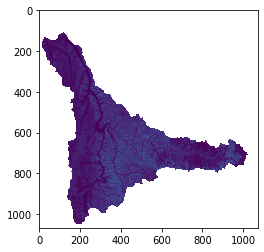

In [37]:
import matplotlib.pyplot as plt
plt.imshow(np.ma.masked_less(arr, 0))

In [44]:
# do em all
with ProcessPoolExecutor(20) as e:
    result = e.map(resample_one_hand, hand_paths)

## Mosaic 250m files

In [45]:
hand_paths_250m = list(Path('/data/static/hand/250m_average/').glob('*hand.tif'))

In [48]:
mosaic, out_tx = merge(hand_paths_250m)

In [49]:
profile = rio.open(hand_paths_250m[0]).profile

profile['transform'] = out_tx
profile['height'] = mosaic[0].shape[0]
profile['width'] = mosaic[0].shape[1]

In [50]:
profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 18572, 'height': 11990, 'count': 1, 'crs': CRS.from_wkt('PROJCS["Lambert_Conformal_Conic",GEOGCS["Unknown datum based upon the Authalic Sphere",DATUM["Not_specified_based_on_Authalic_Sphere",SPHEROID["Sphere",6370000,0,AUTHORITY["EPSG","7035"]],AUTHORITY["EPSG","6035"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",40],PARAMETER["central_meridian",-97],PARAMETER["standard_parallel_1",30],PARAMETER["standard_parallel_2",60],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(250.0, 0.0, -2294366.221425583,
       0.0, -250.0, 1391078.1769092027), 'blockxsize': 512, 'blockysize': 128, 'tiled': True, 'interleave': 'band'}

In [51]:
with rio.open('/data/static/hand/mosaic_250m_avg.tif', 'w', **profile) as dst:
    dst.write(mosaic)

Ended up with some NaN holes in the mosaic, but it's mostly good. Might have to come back and fix those later.

## Create a lat/lon version
Useful for testing and evaluating some stream gauge rasterization

In [53]:
dst_crs = "EPSG:4269"

In [59]:
with rio.open('/data/static/hand/mosaic_250m_avg.tif', 'r') as src:
    transform, width, height = calculate_default_transform(
        src.crs, 
        dst_crs,
        src.width,
        src.height,
        *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height,
        "compress": "deflate"
    })

    with rio.open('/data/static/hand/mosaic_250m_avg_EPSG4269.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.bilinear)